In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spotify_data = pd.read_csv('https://raw.githubusercontent.com/victorgrubio/lsma/master/02-exploratory-data-analysis/Spotify_Features.csv')
spotify_data.head()

,speechiness,key,time_signature,liveness,loudness,duration_ms,danceability,duration,valence,acousticness,spotify_id,volume_number,energy,tempo,instrumentalness,mode,number,artist,title
0,0.1400,4.0,4.0,0.0521,-6.055,267267.0,0.891,266,0.820,0.20200,spotify:track:1AWQoqb9bSvzTjaLralEkT,13,0.714,100.972,0.000234,0.0,1,Justin Timberlake,Rock Your Body
1,0.0555,10.0,4.0,0.0853,-5.416,222040.0,0.741,221,0.362,0.03980,spotify:track:7AUfOfYTfiHhgg2Pw1aTpw,13,0.575,93.992,0.127000,0.0,2,Jennifer Lopez,I'm Glad
2,0.2160,3.0,4.0,0.0504,-6.562,205000.0,0.676,203,0.533,0.02410,spotify:track:5UrbZaqIsclBE9IAcnG43M,13,0.561,89.947,0.000000,0.0,3,B2K,Girlfriend
3,0.3010,1.0,4.0,0.0518,-4.857,280053.0,0.691,229,0.877,0.01860,spotify:track:6JW8DqCEOWaj8z5AIx4ugf,13,0.858,92.773,0.000000,1.0,4,Jay-Z,Excuse Me Miss
4,0.2440,5.0,4.0,0.0908,-7.114,268333.0,0.573,218,0.578,0.00029,spotify:track:5DLkPmyenHS2uJclC8nPCA,13,0.606,176.449,0.000000,0.0,5,Ginuwine featuring Baby,Hell Yeah


## Data cleaning
We are going to explore the data in order to find missing values. Then we will choose to remove the ones without relevant information and predict the rows with small amount of NaN features

In [3]:
# Plot all columns with NaN values in order to perform cleaning
df1 = spotify_data[spotify_data.isnull().any(axis=1)]
df1

,speechiness,key,time_signature,liveness,loudness,duration_ms,danceability,duration,valence,acousticness,spotify_id,volume_number,energy,tempo,instrumentalness,mode,number,artist,title
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,251,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,16,Taylor Swift,Fearless
98,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208,NaN,NaN,NaN,33,NaN,NaN,NaN,NaN,19,Jaicko,Fast Forward
106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,6,Christina Milian,AM to PM
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,14,JIVEjones,"Me, Myself & I"
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192,NaN,NaN,NaN,17,NaN,NaN,NaN,NaN,11,JoJo,Baby It's You
220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201,NaN,NaN,NaN,28,NaN,NaN,NaN,NaN,20,Taylor Swift,Our Song
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,218,NaN,NaN,NaN,46,NaN,NaN,NaN,NaN,6,Taylor Swift,I Knew You Were Trouble
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227,NaN,NaN,NaN,47,NaN,NaN,NaN,NaN,15,Taylor Swift,22
352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,272,NaN,NaN,NaN,11,NaN,NaN,NaN,NaN,12,Aaliyah,I Care 4 U
361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231,NaN,NaN,NaN,54,NaN,NaN,NaN,NaN,1,Taylor Swift,Blank Space


In [4]:
# Show amount of Missing values by feature
spotify_data_na = (spotify_data.isnull().sum() / len(spotify_data)) * 100
spotify_data_na = spotify_data_na.drop(spotify_data_na[spotify_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :spotify_data_na})
missing_data

,Missing Ratio
time_signature,2.685110
mode,2.603743
instrumentalness,2.603743
tempo,2.603743
energy,2.603743
spotify_id,2.603743
acousticness,2.603743
valence,2.603743
danceability,2.603743
duration_ms,2.603743


Text(0.5, 1.0, 'Percent missing data by feature')

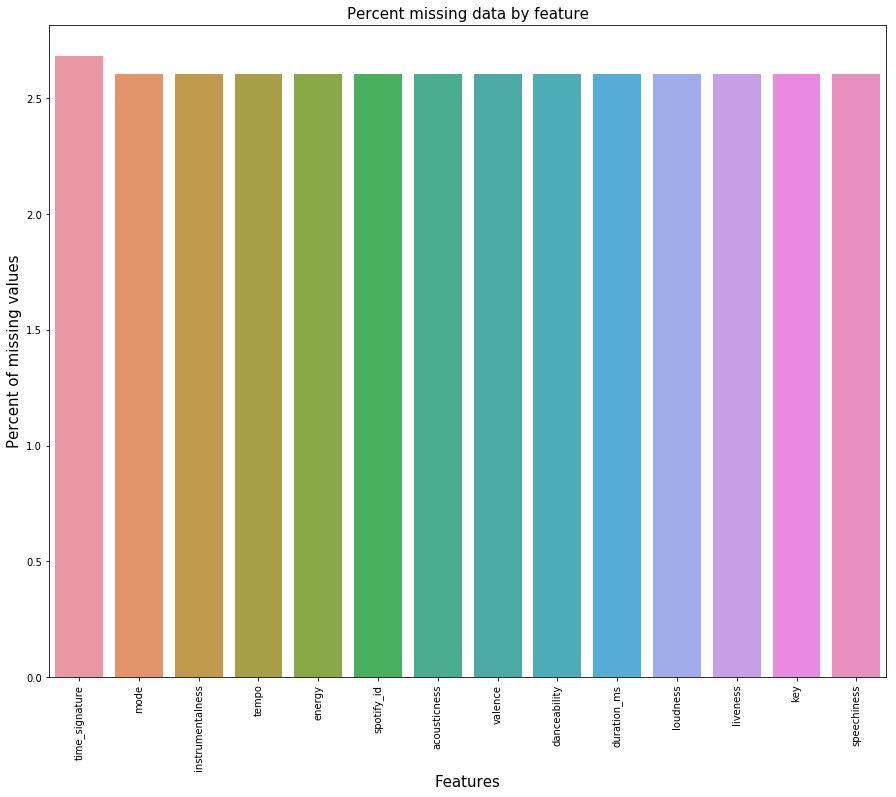

In [5]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=spotify_data_na.index, y=spotify_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

As we can observe, the time signature has slightly more missing values. We will try to find the "extra" missing values from this feature and predict it using the rest of the data.

In [6]:
#Clean all values with more than 3 NaN as they are useless
spotify_data = spotify_data.dropna(thresh=10,how='any',axis=0)

In [7]:
# Show the remaining missing values
nan_rows = spotify_data[spotify_data.isnull().any(axis=1)]
# Create a dataset without any empty value
df_notnan = spotify_data.dropna()
# Show the rows with NaN values that could be useful
index_missing = nan_rows.index[0]
nan_rows

,speechiness,key,time_signature,liveness,loudness,duration_ms,danceability,duration,valence,acousticness,spotify_id,volume_number,energy,tempo,instrumentalness,mode,number,artist,title
549,0.387,0.0,NaN,0.288,-6.9,257560.0,0.619,232,0.395,0.184,spotify:track:5OiLJ8tjUPFiPX2gVM8fxJ,34,0.539,145.618,0.0,1.0,8,The Black Eyed Peas,Imma Be


As the previous print reveals, only one row contains a missing value of time_signature with all the rest features with info. To predict this value, we are going to implement a KNN Regressor as we are trying to predict a concrete value (not classify it).

In [8]:
# Get missing value using KNN
# Train KNN learner
from sklearn.neighbors import KNeighborsRegressor
clf = KNeighborsRegressor(5, weights='distance')
df_x = df_notnan[df_notnan.columns.difference(['time_signature', 'artist', 'title','spotify_id'])]
df_y = df_notnan.loc[:, df_notnan.columns == 'time_signature']
trained_model = clf.fit(df_x,df_y)

In [9]:
# Predict missing value and setting it to the missing value
predicted_values = trained_model.predict(nan_rows[nan_rows.columns.difference(['time_signature', 'artist', 'title','spotify_id'])])
spotify_data.at[index_missing,'time_signature'] = predicted_values
# Show if we have missing values
spotify_data_na = (spotify_data.isnull().sum() / len(spotify_data)) * 100
spotify_data_na = spotify_data_na.drop(spotify_data_na[spotify_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :spotify_data_na})
missing_data


,Missing Ratio


### NOTE: Code should be improved more multiple cases. This implementation is made for this concrete case.

## Feature Engineering: Exploration
We are going to explore the relationship between variables in order to make predictions easier, as well as for future feature engineering to improve prediction models. First of all, a correlation matrix will be employed to find mentioned relations. Then, we will choose a "main" variable to analyse and the feature to compare it with.
We will end with a statistical analysis of the main feature, trying to find a distribution that "fits" on it, to simplify future statistical analysis.

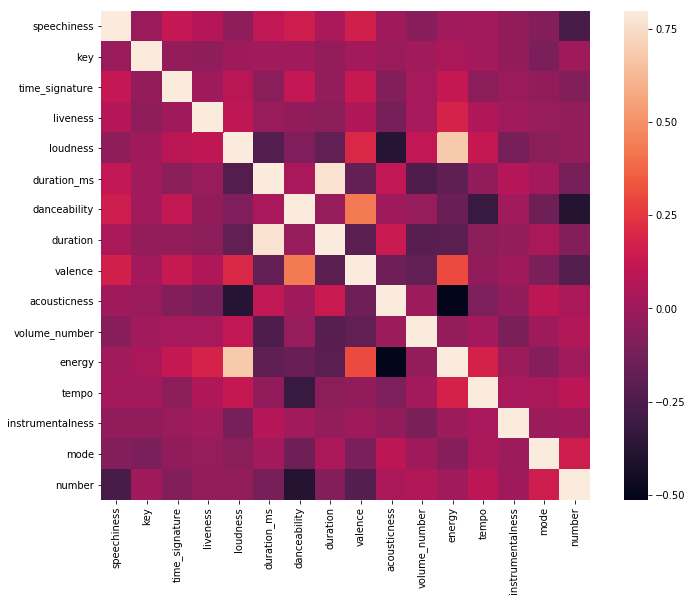

In [10]:
# Correlation Matrix Heatmap
corrmat = spotify_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

Let's start analysing relation between variables for future feature engineering and predictions. 
We define danceability as the main feature. We are going to search the relation between it and valence. We have decided that due to the correlation matrix plot above, as it shows that danceability and valence have a slight direct relation.

In [11]:
var_analysis = 'danceability'
var_compare = 'valence'

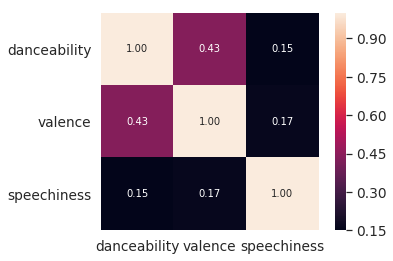

In [12]:
# Top k Heatmap
k = 3 #number of variables for heatmap
cols = corrmat.nlargest(k, var_analysis)[var_analysis].index
cm = np.corrcoef(spotify_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [13]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,danceability
1,valence
2,speechiness


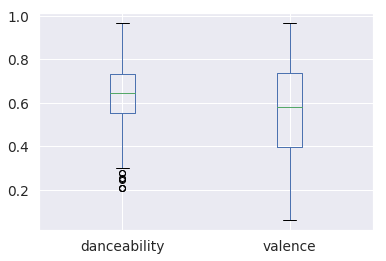

In [14]:
# Comparison
spotify_data[[var_analysis,var_compare]].boxplot()


 mu = 0.64 and sigma = 0.13



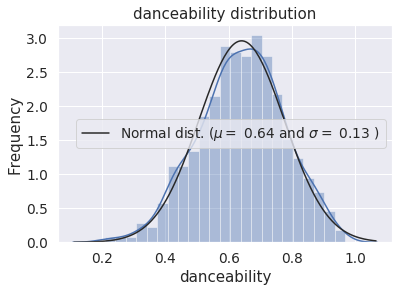

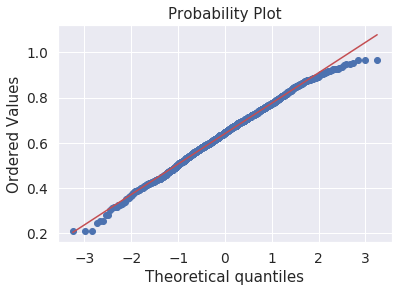

Skewness: -0.180716
Kurtosis: -0.159190


In [15]:
# Plot Histogram
sns.distplot(spotify_data[var_analysis], fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(spotify_data[var_analysis])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('{} distribution'.format(var_analysis))

fig = plt.figure()
res = stats.probplot(spotify_data[var_analysis], plot=plt)
plt.show()

print("Skewness: %f" % spotify_data[var_analysis].skew())
print("Kurtosis: %f" % spotify_data[var_analysis].kurt())

As we can see, the danceability feature has distribution extremely similar to a Gaussian with mu=0.64 and standart deviation = 0.13. This will allow a simplification on statistical operations on the mentionen feature as it can be replaced by a known distribution.